In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from pyphoenix import pyphoenix

# System Parameters
grid_size = 200                 # Grid Size, int this case 200x200
x_max = 20                      # mum; Maximum Distance, meaning the grid will be from -10mum to 10mum
effective_mass = 0.5*5.864E-4   # kg; Effective Mass of the electron, scaled
gamma_c = 0.16                  # Polariton Loss Rate
gamma_r = 1.5 * gamma_c         # Reservoir Loss Rate
R = 0.01                        # Condensation Rate
g_c = 6E-6                      # Polariton-Polariton Coupling
g_r = 2*g_c                     # Polariton-Reservoir Coupling
t_end = 3000                    # ps; End time of the simulation
sample_after = 1999.99          # ps; Time to start sampling the data
window_percent = 0.5            # Inner percentage of the grid window to sample
sampling_rate = 0.5             # ps; Sampling rate of the simulation

# Additional Parameters not required by PHOENIX:
hbar = 6.582119569E-4
dx = x_max/grid_size

# Grid Window
grid_start = int(grid_size/2 - grid_size/2*window_percent)
grid_width = int(grid_size*window_percent)

# Matrix Generation

While PHOENIX can also generate spacial shapes via its envelope syntax, it is usually beneficial to pre-generate all required inputs. This way, we can plot and verify the inputs beforehand.

We generate an X-Y Meshgrid using numpy, fill the pump and potential matrices and plot them. Because we want to vary the first pump amplitude, we create a lambda for the pump creation.

We also plot the inputs for verification purposes. We can save the matrices row wise, noting that PHOENIX also reads the matrices as row major inputs. 


In [2]:
# X-Y Meshgrid
x = np.linspace(-x_max/2, x_max/2, grid_size, endpoint=False)
y = np.linspace(-x_max/2, x_max/2, grid_size, endpoint=False)
X, Y = np.meshgrid(x, y)

# Helper Function to save the numpy matrices into a format PHOENIX can read
def save_matrix(matrix, filename):
    header = f"SIZE {grid_size} {grid_size} {x_max} {x_max} {dx} {dx} PYTHON-GENERATED"
    # if real matrix
    if np.isrealobj(matrix):
        np.savetxt( filename, matrix, header=header, fmt='%.5f' )
    else:
        np.savetxt( filename, matrix.real, header=header, fmt='%.5f' )

## Pump Generation ##

# Spacing shifts both the pump and the potential wells
spacing = 4.0

# Pump 
pump1_amp = 8.0
pump1_w = 1.0
pump2_amp = 12.0
pump2_w = 1.0

# We create a lambda for the pump because we are going to vary the pump amplitude in the optimization and scanning process
generate_pump = lambda pump_varied: pump_varied*np.exp(-np.sqrt((X+spacing/2)**2 + Y**2) / (pump1_w**2) ) + pump2_amp*np.exp(-np.sqrt( (X-spacing/2)**2 + Y**2 ) / (pump2_w**2) )
pump = generate_pump(pump1_amp)

# Save the pump using X,Y,Re,Im format
save_matrix(pump, "pump_plus.txt")

## Potential Generation ##

potential1_amp = -2E-3
potential1_w = 1.5
potential2_amp = -2.2E-3
potential2_w = 1.5
potential_order = 2

potential = potential1_amp*np.exp(-( ((X+spacing/2)**2 + Y**2)/(potential1_w**2) )**potential_order ) + potential2_amp*np.exp(-( ((X-spacing/2)**2 + Y**2)/(potential2_w**2) )**potential_order)

# Save the potential using X,Y,Re,Im format
save_matrix(potential, "potential_plus.txt")

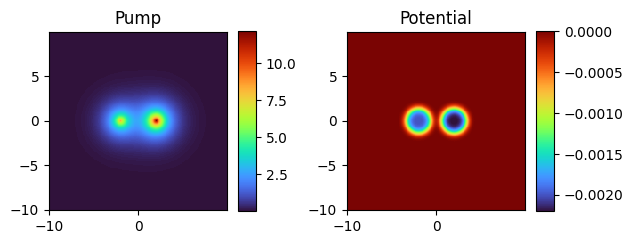

In [3]:
# Plot the pump and potential
fig, (ax1,ax2) = plt.subplots(1,2)
plt_pump = ax1.pcolormesh(X,Y,pump, cmap="turbo")
ax1.set_title("Pump")
plt_pot = ax2.pcolormesh(X,Y,potential, cmap="turbo")
ax2.set_title("Potential")

# Colorbars
fig.colorbar(plt_pump, shrink=0.4, aspect=10)
fig.colorbar(plt_pot, shrink=0.4, aspect=10)
[ax.set_aspect("equal") for ax in (ax1,ax2)]

plt.tight_layout()

# Run a Simulation with PHOENIX

We also plot the test calculation. The density for the given set of parameters should approach zero.

In [4]:
def run(t_max: float = t_end, history: bool = False):
    # define simulation parameters with a dict
    config={
        "N":[grid_size,grid_size],  # Set the grid size in points
        "L":[x_max,x_max],          # Set the grid size in mum
        "meff":effective_mass,      # Set the effective mass
        "tmax":t_max,               # Set the end time  
        "tstep":0.02,               # Set the time step
        "outEvery": sampling_rate,  # Set sample rate 
        "gc":g_c,                   # Set the coupling constants
        "gr":g_r,                   # Set the coupling constants
        "R":R,                      # Set the condensation rate
        "gammaR": gamma_r,          # Set the reservoir loss rate
        "gammaC": gamma_c,          # Set the polariton loss rate
        "boundary": ["periodic","periodic"], # Set periodic boundary conditions in both directions
        "fftEvery": 0.001,         # Set the FFT sample rate
        "fftMask": [1.0,"add",0.2,0.2,0,0,"both",10,"none","gauss+local+noDivide"]
    }
    # Add pump 
    config["pump"]=["load","pump_plus.txt","1","add","both"]
    # Load the pump as the initial state
    config["initialState"]=["load","pump_plus.txt",1,"add","both"]
    config["initRandom"] = [1E-7,"random"]
    # Load the pump as the initial reservoir
    config["initialReservoir"]=["load","pump_plus.txt",1,"add","both"]
    # Load the potential
    config["potential"]=["load","potential_plus.txt",1,"add","both"]
    # Set output
    if history:
        config["output"]="wavefunction"
        config["historyMatrix"]=[grid_start,grid_start+grid_width,grid_start,grid_start+grid_width,1] # Add Time Matrix History output
        config["historyTime"]=[sample_after,1]   # Add Time Matrix History output
         
    ph=pyphoenix.pyphoenix(debug=False,precision="fp32",doprint=False)
    ph.run(config)
    return ph
    
ph=run(t_max=5000)    

### Plotting
PHOENIX saves outputs using one row per line, saving real parts first. This means, for our 200x200 complex matrices, PHOENIX will output a textfile containing a 400x200 (rows,cols) matrix. When loading the real and imaginary parts of the result, we can also calculate the phase using `np.angle`.

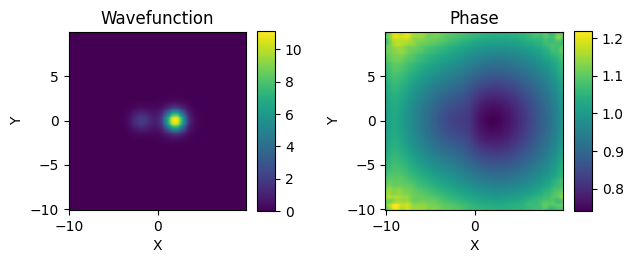

In [5]:
# Plot Results
data = np.loadtxt( os.path.join(ph.get_result_path(), "wavefunction_plus.txt") )
re,im = data[:grid_size,:], data[grid_size:,:]
psi = (re + 1j*im).reshape(grid_size,grid_size)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.set_title("Wavefunction")
plt_psi = ax1.pcolormesh(X,Y,np.abs(psi)**2)
ax2.set_title("Phase")
plt_phase = ax2.pcolormesh(X,Y,np.angle(psi))

for ax,plot in zip((ax1,ax2),(plt_psi,plt_phase)):
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect("equal")
    fig.colorbar(plot, ax=ax, shrink=0.4, aspect=10)

plt.tight_layout()

# Fourier Transform

Now we want to calculate the Fourier Transform of a specific time slice of the matrix. While PHOENIX can output a single X-Slice History Matrix, we can also simply output a history of complete matrices (at a lower resolution) for advanced data processing.

While we're on it, we may as well reconstruct the wavefunctions into a video!

We create functions to prepare and evaluate the data required for the Fourier Transform to reuse them in a parameter scan later.

In [6]:
# Execute PHOENIX with a specific pump amplitude
def generatePHOENIXData(pump_amp) -> None:
    """
    Generate the pump, save the pump, and generate the runstring
    Then, remove the previous timeoutput folder if it exists,
    and execute PHOENIX.
    """
    print(f"Running PHOENIX with pump amplitude {pump_amp}")
    pump = generate_pump(pump_amp)
    save_matrix(pump, "pump_plus.txt")
    ph=run( history=True )

    # Clear contents of the results folder
    timeoutput_folder = os.path.join(ph.get_result_path(), "timeoutput")
    return timeoutput_folder

In [7]:
def readPHOENIXData(timeoutput_folder:str) -> tuple:
    """
    After PHOENIX has finished, read in the timeoutput files,
    reconstruct the wavefunctions, and calculate the Fourier
    Transform of the wavefunctions.
    Return the wavefunctions, times, wavefunction cuts, Fourier
    Transform, and the subgrid size.
    """
    # Read in all matrix files in the results/timeoutput folder
    files = os.listdir( timeoutput_folder )
    # Sort the files by ascending time
    files.sort(key=lambda x: float(x.split("_")[-1].replace(".txt", "")))

    print(f"Reading {len(files)} timeoutput files")

    # Read in all the timeoutput files. .shape[1] is the subgrid size
    timeoutput = [ np.loadtxt( os.path.join(timeoutput_folder, file) ) for file in files ]
    headers = [ open( os.path.join(timeoutput_folder, file) ).readline() for file in files ]
    subgrid_size = int(timeoutput[0].shape[1])
    print(f"Grid Window Size: {subgrid_size}")

    # Reconstruct the wavefunctions
    wavefunctions = [data[:subgrid_size,:] + 1j*data[subgrid_size:,:] for data in timeoutput]
    times = [ float(header.split()[-4]) for header in headers ]

    samples = len(times)
    # Extract a cut of the wavefunction at a specific Y coordinate
    y_index = int(subgrid_size/2)
    wavefunction_cuts = np.array([ wavefunction[y_index,:] for wavefunction in wavefunctions ])
    
    real_dt = times[1] - times[0]
    real_dx = x_max / grid_size* window_percent 

    # Calculate the Fourier Transform Frequencies
    W = 2*np.pi*np.linspace(-0.5, 0.5, samples) / real_dt

    # Calculate the Fourier Transform of the wavefunctions
    fft = np.array([ np.abs(np.fft.fftshift(np.fft.fft(wavefunction_cut))) for wavefunction_cut in wavefunction_cuts.T ])

    x = np.linspace(-x_max*window_percent/2, x_max*window_percent/2, subgrid_size, endpoint=False)
    return wavefunctions,times,x,wavefunction_cuts,fft,W,subgrid_size,real_dx,real_dt

### Example

We will now perform an example calculation to test our functions. We will then also recreate the simulation using matplotlibs animation functions.

In [8]:
# As a test, we prepare the data for a fixed pump amplitude
pump_amp = 8
timeoutput_folder=generatePHOENIXData(pump_amp)

Running PHOENIX with pump amplitude 8


In [9]:
# Read in the data
wavefunctions,times,x,wavefunction_cuts,fft,W,subgrid_size,real_dx,real_dt = readPHOENIXData(timeoutput_folder)

Reading 2001 timeoutput files
Grid Window Size: 100


### Animation

As we have already saved all of the matrices to the disk and loaded them into this notebook, we might as well reconstruct them into a video.

We create a X-Y-subgrid, plot the initial wavefunction and then animate the remaining matrices.

We save the animation into a .mp4 file.

path of video /home/robert/git/PHOENIX/examples/example_2/phoenix_tmp/phoenix_tmp16_clat8/timeoutput/wavefunction_8.mp4
Animating frame 0/2001

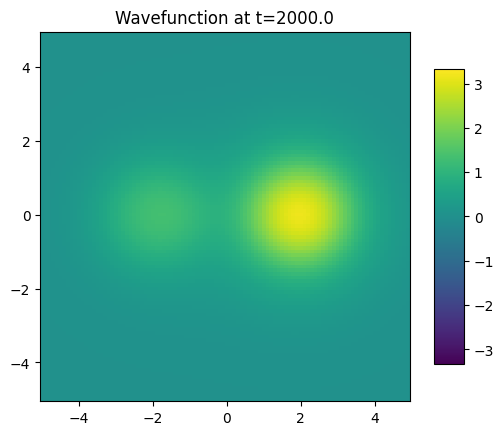

In [10]:
# Create an animation
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()
ax.set_title("Wavefunction")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt_psi = ax.pcolormesh(x,x,np.abs(wavefunctions[0])**2)
cbar = fig.colorbar(plt_psi, ax=ax, shrink=0.8, aspect=10)
ax.set_aspect("equal")

# Limit to maximum of abs(psi)
m_max = np.max(np.abs(wavefunctions))

def animate(i):
    ax.clear()
    plt_psi = ax.pcolormesh(x,x,np.real(wavefunctions[i]), vmin=-m_max, vmax=m_max)
    # set data of the plot to the new wavefunction
    ax.set_title(f"Wavefunction at t={times[i]}")
    # Set Colorbar data of the new plot
    plt_psi.colorbar = cbar
    plt_psi.colorbar.mappable = plt_psi
    plt_psi.colorbar.update_normal(plt_psi)

    print(f"Animating frame {i}/{len(times)}",end="\r")
    return plt_psi

anim = FuncAnimation(fig, animate, frames=len(wavefunctions), interval=100, repeat=True)
videopath=os.path.join(timeoutput_folder, f"wavefunction_{pump_amp}.mp4")
anim.save( videopath, fps=15 )
print("path of video",videopath)

### Wavefunction Cut Animation

We can also animate the cut that we have just extracted from the matrices.

We perform a similar animation as before, using a simple line plot instead of a pcolormesh.

path of video /home/robert/git/PHOENIX/examples/example_2/phoenix_tmp/phoenix_tmp16_clat8/timeoutput/wavefunction_cut_8.mp4
Animating frame 0/2001

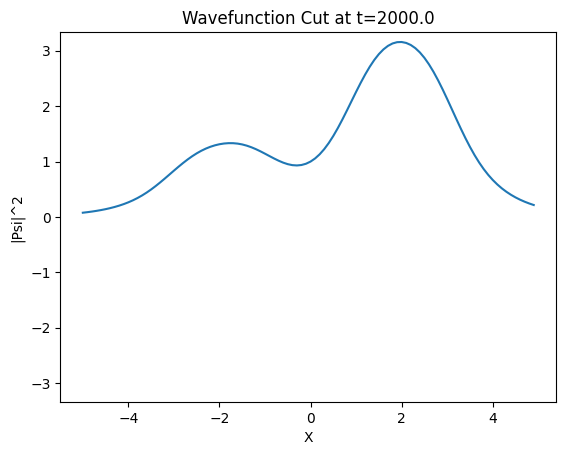

In [11]:
# Animate the wavefunction cuts
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()
ax.set_title("Wavefunction Cut")
ax.set_xlabel("X")
ax.set_ylabel("|Psi|^2")

plt_psi = ax.plot(x,wavefunction_cuts[0].real)

y_lim = wavefunction_cuts.real.max()
ax.set_ylim(-y_lim, y_lim)

def animate(i):
    # Set data
    plt_psi[0].set_ydata(wavefunction_cuts[i].real)
    ax.set_title(f"Wavefunction Cut at t={times[i]}")

    print(f"Animating frame {i}/{len(times)}",end="\r")
    return plt_psi

anim = FuncAnimation(fig, animate, frames=len(wavefunctions), interval=100, repeat=True)
videopath=os.path.join(timeoutput_folder, f"wavefunction_cut_{pump_amp}.mp4")
anim.save(videopath, fps=15)
print("path of video",videopath)

## Fourier Transform Plot

Now that we have generated and loaded the data from PHOENIX and calculated the Fourier Transform of each time slice, we can plot the FFT.

FFT Shape (100, 2001)
Energy: [1.23150432] -> [0.81059087] meV


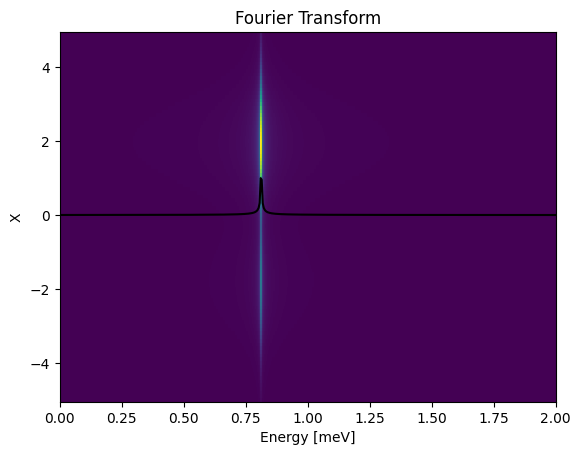

In [12]:
# Get the Maximum and Plot the Fourier Transform 
# Plot the Fourier Transform
fig, ax = plt.subplots()
ax.set_title("Fourier Transform")
ax.set_ylabel("X")
ax.set_xlabel("Energy [meV]")
ax.set_xlim(0,2)
#ax.set_xlim(0.5,1)
ax.pcolormesh(W*hbar*1E3,x,fft)
print("FFT Shape", fft.shape)
# Integrate the FFT on the y-axis
fft_integrated = np.sum(fft, axis=0)

# Normalize the FFT
fft_integrated /= np.max(fft_integrated)
ax.plot(W*hbar*1E3, fft_integrated, color="black")
peaks, _ = find_peaks(fft_integrated, height=0.3)
energy = W[peaks]*hbar*1E3
print(f"Energy: {W[peaks]} -> {energy} meV")

## Parameter Scan

Now that we have prepared the execution of PHOENIX, defined a function to read-in the generated data and prepared the Fourier Transformation, we can finally generate a parameter scan of the first pump amplitude.

We overwrite the results every iteration to save on disk space. We could also update the result path accordingly to keep the data.

In [14]:
# Run Scan of the pump amplitude
pump_amp_scan = np.linspace(0, 15, 16, endpoint=True)

fft_cost_scan = []
fft_energy_peaks = []

for pump_amp in pump_amp_scan:
    timeoutput_folder=generatePHOENIXData(pump_amp)
    wavefunctions,times,x,wavefunction_cuts,fft,W,subgrid_size,real_dx,real_dt = readPHOENIXData(timeoutput_folder)
    # Integrate the FFT on the y-axis
    fft_integrated = np.sum(fft, axis=0)
    # Normalize the FFT
    fft_integrated /= np.max(fft_integrated)
    # Analyze the peaks
    peaks, _ = find_peaks(fft_integrated, height=0.3)
    energy = W[peaks]*hbar*1E3
    print(f"Energy: {W[peaks]} Hz -> {energy} meV")
    fft_energy_peaks.append( energy )

    # Similar to before, we also calculate a cost value. In this case, since we already loaded all of the wavefunctions,
    # we will do an integrated cost instead of a final-value cost.
    cost = np.sum( [ np.sum(np.abs(wavefunction)**2) for wavefunction in wavefunctions ] )
    fft_cost_scan.append( cost )

# Save the results to disk
max_length = max( [ len(energy) for energy in fft_energy_peaks ] )
# Pad energies with NaNs to make them the same length
fft_energy_peaks = [ np.pad(energy, (0,max_length-len(energy)), constant_values=np.nan) for energy in fft_energy_peaks ]
np.savetxt("fft_cost_scan.txt", np.array([pump_amp_scan, fft_cost_scan, *np.array(fft_energy_peaks).T]).T )

Running PHOENIX with pump amplitude 0.0
Reading 2001 timeoutput files
Grid Window Size: 100
Energy: [1.17495565] Hz -> [0.77336986] meV
Running PHOENIX with pump amplitude 1.0
Reading 2001 timeoutput files
Grid Window Size: 100
Energy: [1.16867247] Hz -> [0.76923419] meV
Running PHOENIX with pump amplitude 2.0
Reading 2001 timeoutput files
Grid Window Size: 100
Energy: [1.1561061] Hz -> [0.76096286] meV
Running PHOENIX with pump amplitude 3.0
Reading 2001 timeoutput files
Grid Window Size: 100
Energy: [1.14353973] Hz -> [0.75269152] meV
Running PHOENIX with pump amplitude 4.0
Reading 2001 timeoutput files
Grid Window Size: 100
Energy: [1.12469017] Hz -> [0.74028452] meV
Running PHOENIX with pump amplitude 5.0
Reading 2001 timeoutput files
Grid Window Size: 100
Energy: [1.23150432] Hz -> [0.81059087] meV
Running PHOENIX with pump amplitude 6.0
Reading 2001 timeoutput files
Grid Window Size: 100
Energy: [1.23778751] Hz -> [0.81472654] meV
Running PHOENIX with pump amplitude 7.0
Reading 2

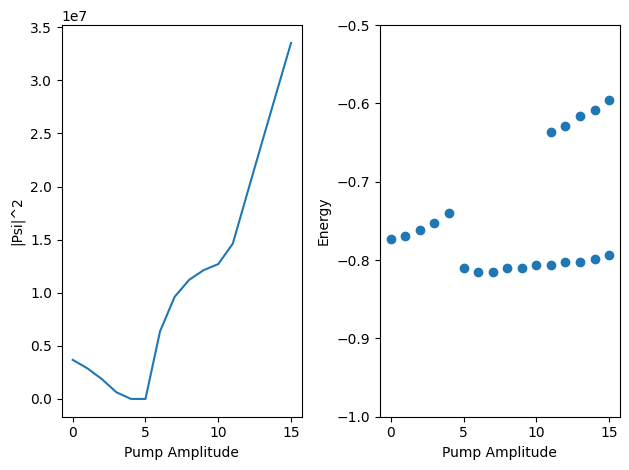

In [15]:
# Load the .txt
pump_amp_scan, fft_cost_scan, *fft_energies = np.loadtxt("fft_cost_scan.txt", unpack=True )

# Plot the results
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(pump_amp_scan, fft_cost_scan)
ax1.set_xlabel("Pump Amplitude")
ax1.set_ylabel("|Psi|^2")
#ax2.plot(pump_amp_scan, -fft_energy_low)
#ax2.plot(pump_amp_scan, -fft_energy_high)
for energy in fft_energies:
    ax2.plot(pump_amp_scan, -energy, marker="o", linewidth = 0, c = "C0")
ax2.set_xlabel("Pump Amplitude")
ax2.set_ylabel("Energy")
#ax1.set_ylim(0,0.75E7)
#ax1.set_xlim(0,10)
ax2.set_ylim(-1,-0.5)
plt.tight_layout()

## Optimization

Alternatively, we can also use a simple optimizer to find the exceptional point.

In [19]:
from scipy.optimize import minimize

def cost_function(parameters):
    """
    Cost function for the optimization
    |Psi|^2 has to be minimized
    """
    pump_amp = parameters[0]
    # Generate the pump
    timeoutput_folder=generatePHOENIXData(pump_amp)
    wavefunctions,times,x,wavefunction_cuts,fft,W,subgrid_size,real_dx,real_dt = readPHOENIXData(timeoutput_folder)
    cost_sum = np.sum( [ np.sum(np.abs(wavefunction)**2) for wavefunction in wavefunctions ] )
    cost_max = np.max( [ np.sum(np.abs(wavefunction)**2) for wavefunction in wavefunctions ] )
    print(f" -> Cost Sum: {cost_sum}, Max: {cost_max}")
    return cost_sum, cost_max

In [ ]:
# Run the Scipy Optimization
res = minimize(lambda param: cost_function(param)[0], x0=[6], method="Nelder-Mead", options={"maxiter": 15, "disp": True})

Running PHOENIX with pump amplitude 6.0
Running PHOENIX with pump amplitude 6.0
Reading 2001 timeoutput files
Grid Window Size: 100
 -> Cost Sum: 6359182.297881906, Max: 3178.0117174578027
Running PHOENIX with pump amplitude 6.300000000000001
Running PHOENIX with pump amplitude 6.300000000000001
Reading 2001 timeoutput files
Grid Window Size: 100
 -> Cost Sum: 7638373.712376289, Max: 3817.2885828462613
Running PHOENIX with pump amplitude 5.699999999999999
Running PHOENIX with pump amplitude 5.699999999999999
Reading 2001 timeoutput files
Grid Window Size: 100
 -> Cost Sum: 4534014.42738307, Max: 2265.890612891316
Running PHOENIX with pump amplitude 5.399999999999999
Running PHOENIX with pump amplitude 5.399999999999999
Reading 2001 timeoutput files
Grid Window Size: 100
 -> Cost Sum: 1424786.9901233674, Max: 723.9051771936951
Running PHOENIX with pump amplitude 4.799999999999997
Running PHOENIX with pump amplitude 4.799999999999997
Reading 2001 timeoutput files
Grid Window Size: 100
 -